In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import warnings
import os
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')

 identify the best algorithms and optimal cluster numbers, aiming for clearer customer segmentation.

In [ ]:
plt.style.use('default')
sns.set_palette("husl")

In [3]:
scaled_data = pd.read_csv(r"data\03_scaled_proprocessed_marketing_campaign.csv", index_col=0)
print(f"Data shape: {scaled_data.shape}")
print(f"Features: {scaled_data.columns.tolist()}")
print()

Data shape: (2184, 17)
Features: ['Education', 'Marital_Status', 'Income', 'Recency', 'Response', 'Age', 'Customer_Since', 'Total_Spent', 'RatioWines', 'RatioFruits', 'RatioMeatProducts', 'RatioFishProducts', 'RatioSweetProducts', 'RatioGoldProds', 'Total_Accepted_Campaign', 'Total_Purchase', 'Total_Web_Engagement']



In [4]:
# Prepare data for clustering
X = scaled_data.values
feature_names = scaled_data.columns.tolist()

In [5]:
# PCA Analysis
# Reduces the 17-dimensional dataset to a lower-dimensional space for clustering
# Identify patterns by projecting data onto axes that maximize variance
pca = PCA()
X_pca = pca.fit_transform(X)

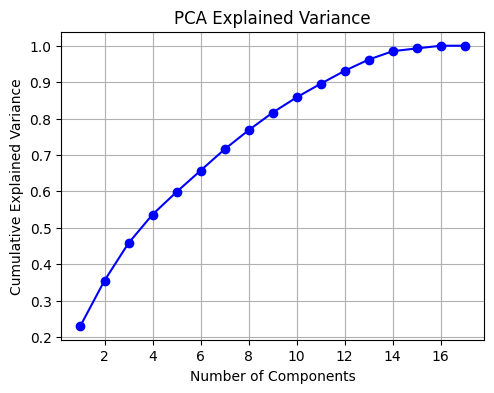

In [6]:
# Plot explained variance
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.savefig("plots/pca_explained_variance.png", dpi=300, bbox_inches='tight')
plt.grid(True)

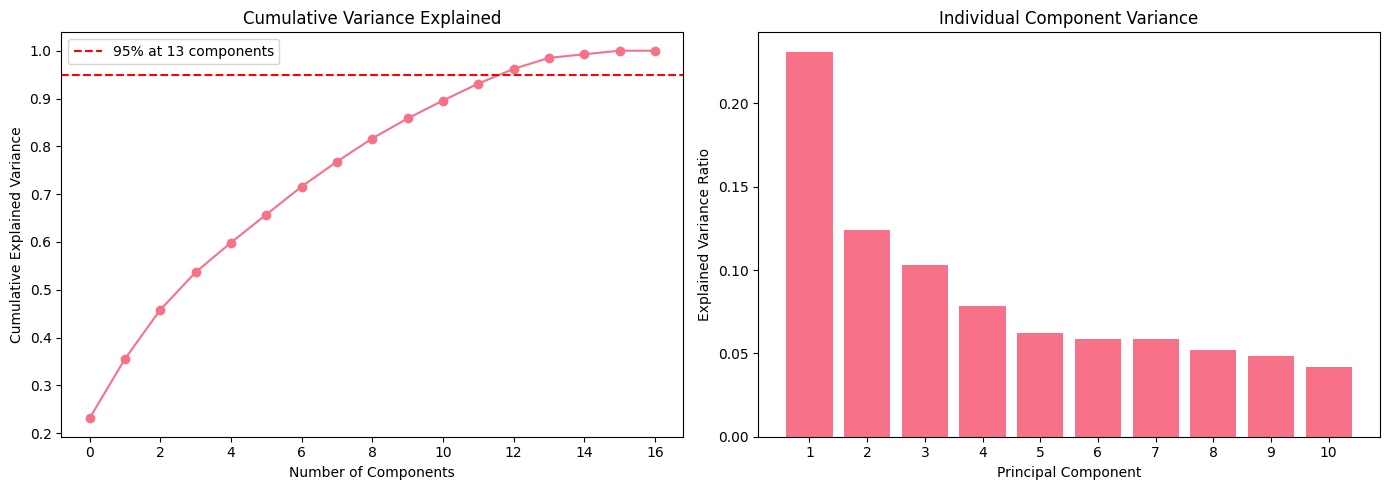

Components needed for 95% variance: 13
First 5 components explain: 0.598 of variance


In [7]:
# Find number of components for 95% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1

plt.figure(figsize=(14, 5)) 

# Cumulative variance plot with 95% line
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label=f'95% at {n_components_95} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained')
plt.legend()

# Bar chart of first 10 components
plt.subplot(1, 2, 2)
plt.bar(range(1, min(11, len(pca.explained_variance_ratio_) + 1)), 
        pca.explained_variance_ratio_[:10])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Component Variance')
plt.xticks(range(1, min(11, len(pca.explained_variance_ratio_) + 1)))

plt.tight_layout()
plt.savefig("plots/pca_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Components needed for 95% variance: {n_components_95}")
print(f"First 5 components explain: {np.sum(pca.explained_variance_ratio_[:5]):.3f} of variance")


Gradual decline in explained variance per component

In [8]:
pca_optimal = PCA(n_components=n_components_95)
X_pca_optimal = pca_optimal.fit_transform(X)

try out another alternative dimensionality reduction

In [9]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

Clustering Algorithm Comparison

In [10]:
# Define range of cluster numbers to test
cluster_range = range(2, 11)
algorithms = {
    'KMeans': KMeans,
    'AgglomerativeClustering': AgglomerativeClustering,
    'GaussianMixture': GaussianMixture
}

In [14]:
# Store results
clustering_results = {}

for alg_name, alg_class in algorithms.items():
    print(f"Testing {alg_name}")
    clustering_results[alg_name] = {
        'silhouette': [],
        'calinski_harabasz': [],
        'davies_bouldin': [],
        'inertia': [] if alg_name == 'KMeans' else None
    }
    
    for n_clusters in cluster_range:
        if alg_name == 'GaussianMixture':
            model = alg_class(n_components=n_clusters, random_state=42)
            labels = model.fit_predict(X_pca_optimal)
        elif alg_name == 'AgglomerativeClustering':
            model = alg_class(n_clusters=n_clusters)
            labels = model.fit_predict(X_pca_optimal)
        else:
            model = alg_class(n_clusters=n_clusters, random_state=42)
            labels = model.fit_predict(X_pca_optimal)
        
        # Calculate metrics
        sil_score = silhouette_score(X_pca_optimal, labels)
        ch_score = calinski_harabasz_score(X_pca_optimal, labels)
        db_score = davies_bouldin_score(X_pca_optimal, labels)
        
        clustering_results[alg_name]['silhouette'].append(sil_score)
        clustering_results[alg_name]['calinski_harabasz'].append(ch_score)
        clustering_results[alg_name]['davies_bouldin'].append(db_score)
        
        if alg_name == 'KMeans':
            clustering_results[alg_name]['inertia'].append(model.inertia_)

    print(clustering_results)


Testing KMeans
{'KMeans': {'silhouette': [0.1559891203731964, 0.13661184620453445, 0.12261933508112821, 0.1291405188248537, 0.1143420516702437, 0.11385099474271822, 0.09814091208768591, 0.10446788677425728, 0.1045862340494635], 'calinski_harabasz': [422.4764224978656, 354.9651238739216, 322.57281985594256, 293.27323747491107, 264.29712441810716, 238.80752736853415, 212.7805210978872, 202.7959752094922, 193.09631677597886], 'davies_bouldin': [2.140929480096599, 2.1625523900110877, 2.062931885795344, 1.9340072038431537, 2.097036893809072, 2.0619349096038553, 2.4066311673107332, 2.3080015225425994, 2.2084517303011815], 'inertia': [29922.255527541693, 26944.948019975498, 24735.36465674668, 23216.644801896105, 22228.561901660538, 21539.10033751105, 21202.529634720908, 20456.639991777338, 19848.75084282018]}}
Testing AgglomerativeClustering
{'KMeans': {'silhouette': [0.1559891203731964, 0.13661184620453445, 0.12261933508112821, 0.1291405188248537, 0.1143420516702437, 0.11385099474271822, 0.0

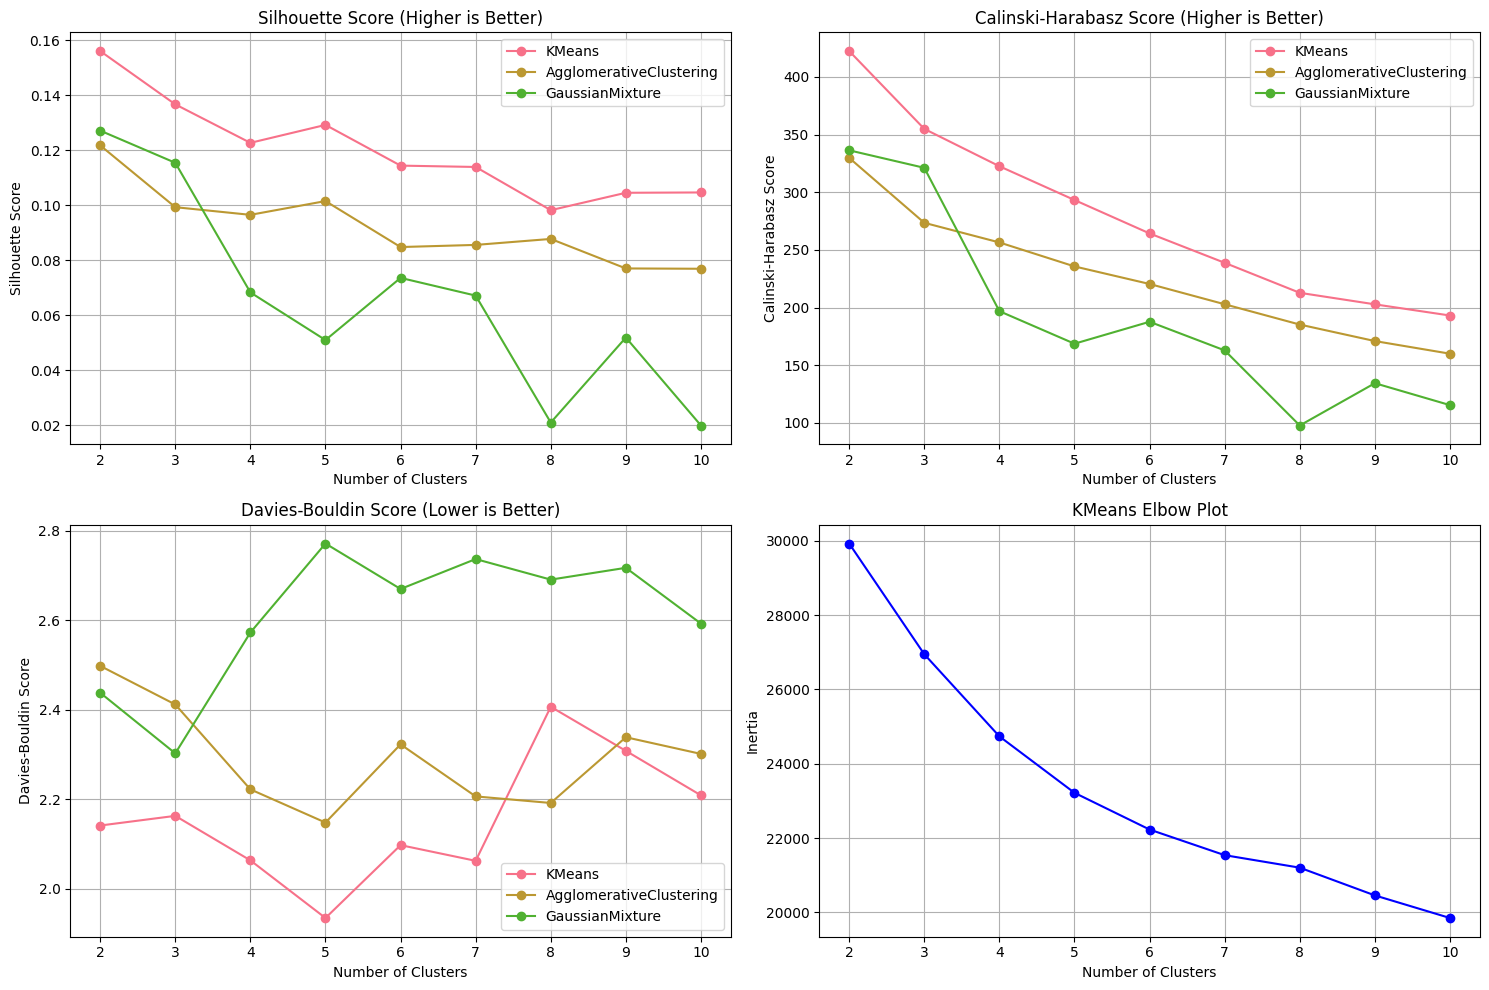

In [56]:
# Plot clustering evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Silhouette Score
axes[0, 0].set_title('Silhouette Score (Higher is Better)')
for alg_name in algorithms.keys():
    axes[0, 0].plot(cluster_range, clustering_results[alg_name]['silhouette'], 
                    'o-', label=alg_name)
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Calinski-Harabasz Score
axes[0, 1].set_title('Calinski-Harabasz Score (Higher is Better)')
for alg_name in algorithms.keys():
    axes[0, 1].plot(cluster_range, clustering_results[alg_name]['calinski_harabasz'], 
                    'o-', label=alg_name)
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].set_ylabel('Calinski-Harabasz Score')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Davies-Bouldin Score
axes[1, 0].set_title('Davies-Bouldin Score (Lower is Better)')
for alg_name in algorithms.keys():
    axes[1, 0].plot(cluster_range, clustering_results[alg_name]['davies_bouldin'], 
                    'o-', label=alg_name)
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].set_ylabel('Davies-Bouldin Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# KMeans Elbow Plot
axes[1, 1].set_title('KMeans Elbow Plot')
axes[1, 1].plot(cluster_range, clustering_results['KMeans']['inertia'], 'o-', color='blue')
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].set_ylabel('Inertia')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('plots/clustering_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

KMeans: Best overall performance with highest silhouette scores


Agglomerative Clustering: Consistent but lower quality scores

Gaussian Mixture: Poor performance, unstable results

# find the optimal # of clusters for each algo

In [57]:
for alg_name in algorithms.keys():
    sil_optimal = cluster_range[np.argmax(clustering_results[alg_name]['silhouette'])]
    ch_optimal = cluster_range[np.argmax(clustering_results[alg_name]['calinski_harabasz'])]
    db_optimal = cluster_range[np.argmin(clustering_results[alg_name]['davies_bouldin'])]
    
    print(f"{alg_name}:")
    print(f"  Silhouette optimal: {sil_optimal}")
    print(f"  Calinski-Harabasz optimal: {ch_optimal}")
    print(f"  Davies-Bouldin optimal: {db_optimal}")
    print()

KMeans:
  Silhouette optimal: 2
  Calinski-Harabasz optimal: 2
  Davies-Bouldin optimal: 5

AgglomerativeClustering:
  Silhouette optimal: 2
  Calinski-Harabasz optimal: 2
  Davies-Bouldin optimal: 5

GaussianMixture:
  Silhouette optimal: 2
  Calinski-Harabasz optimal: 2
  Davies-Bouldin optimal: 3



find the best algo and # of clusters

In [58]:
avg_silhouette = {}
for alg_name in algorithms.keys():
    avg_silhouette[alg_name] = np.mean(clustering_results[alg_name]['silhouette'])

best_algorithm = max(avg_silhouette, key=avg_silhouette.get)
print(f"Best algorithm based on average silhouette score: {best_algorithm}")

# Find optimal clusters for best algorithm
best_n_clusters = cluster_range[np.argmax(clustering_results[best_algorithm]['silhouette'])]
print(f"Optimal number of clusters: {best_n_clusters}")


Best algorithm based on average silhouette score: KMeans
Optimal number of clusters: 2


In [59]:
# fit the best models with the best algo
if best_algorithm == 'GaussianMixture':
    best_model = GaussianMixture(n_components=best_n_clusters, random_state=42)
    best_labels = best_model.fit_predict(X_pca_optimal)
elif best_algorithm == 'AgglomerativeClustering':
    best_model = algorithms[best_algorithm](n_clusters=best_n_clusters)
    best_labels = best_model.fit_predict(X_pca_optimal)
else:
    best_model = algorithms[best_algorithm](n_clusters=best_n_clusters, random_state=42)
    best_labels = best_model.fit_predict(X_pca_optimal)

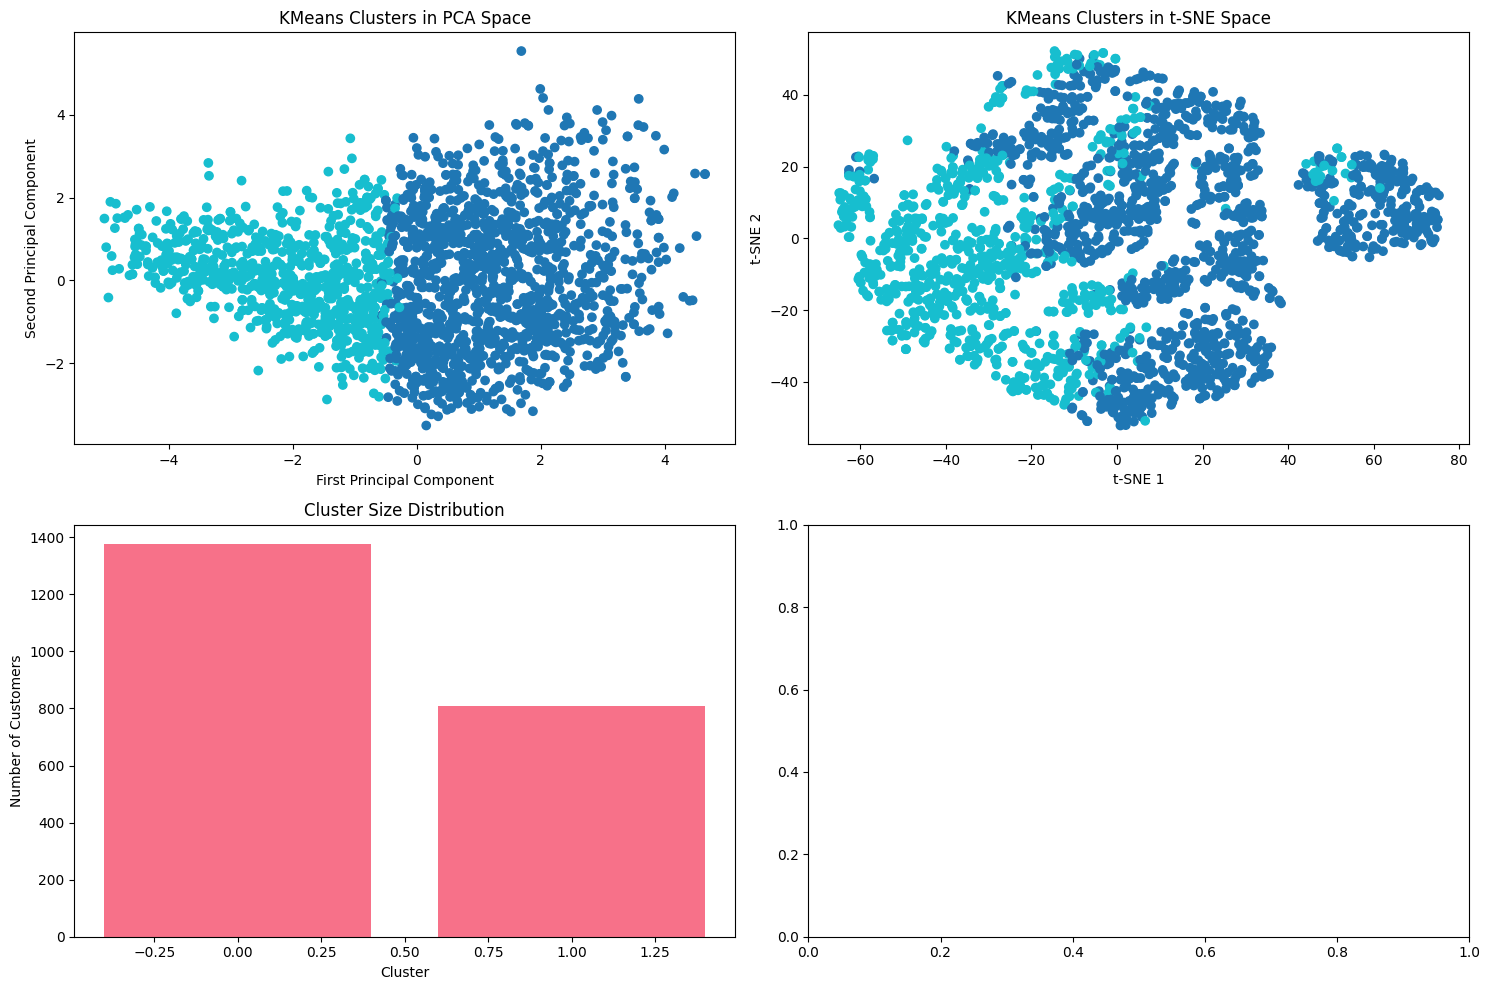

Cluster sizes: [1375  809]


In [77]:
# Visualize clusters in different spaces
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# PCA visualization
axes[0, 0].scatter(X_pca_optimal[:, 0], X_pca_optimal[:, 1], c=best_labels, cmap='tab10')
axes[0, 0].set_title(f'{best_algorithm} Clusters in PCA Space')
axes[0, 0].set_xlabel('First Principal Component')
axes[0, 0].set_ylabel('Second Principal Component')

# t-SNE visualization
axes[0, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=best_labels, cmap='tab10')
axes[0, 1].set_title(f'{best_algorithm} Clusters in t-SNE Space')
axes[0, 1].set_xlabel('t-SNE 1')
axes[0, 1].set_ylabel('t-SNE 2')

# Cluster size distribution
cluster_counts = np.bincount(best_labels)
axes[1, 0].bar(range(len(cluster_counts)), cluster_counts)
axes[1, 0].set_title('Cluster Size Distribution')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Number of Customers')

plt.tight_layout()
plt.savefig('plots/best_clustering_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Cluster sizes: {cluster_counts}")

PCA shows 2 cluster clearly.

t-SNE  shows the 2-cluster structure with distinct groups - one on the left (cyan) and one spread across the middle and right (blue).

Cluster Size Distribution shows an imbalanced split with Cluster 0 having ~1,400 customers and Cluster 1 having ~800 customers

In [78]:
os.makedirs('results/clustering', exist_ok=True)
scaled_data['Cluster'] = best_labels
scaled_data.to_csv('results/clustering/clustered_data_results.csv')

print(f"Best algorithm: {best_algorithm}")
print(f"Optimal clusters: {best_n_clusters}")

print(f"Silhouette score: {silhouette_score(X_pca_optimal, best_labels):.3f}")

Best algorithm: KMeans
Optimal clusters: 2
Silhouette score: 0.156


KMeans emerged as the best algorithm with two clusters and achieving a silhouette score of 0.156 and balanced group sizes. The analysis confirms clear customer segmentation. Now, I will start digging the result in clustered_data


In [82]:
cleaned_data = pd.read_csv("data/02_removed_outliers_redundant.csv", index_col=0)
clustered_data = pd.read_csv("results/clustering/clustered_data_results.csv", index_col=0)

In [83]:
print(f"Data shape: {clustered_data.shape}")
print(f"Cluster distribution: {clustered_data['Cluster'].value_counts().sort_index()}")
print()

Data shape: (2184, 18)
Cluster distribution: Cluster
0    1375
1     809
Name: count, dtype: int64



In [87]:
# analyze cluster characteristics using original (non-scaled) data
cluster_profiles = {}
for cluster_id in sorted(clustered_data['Cluster'].unique()):
    cluster_mask = clustered_data['Cluster'] == cluster_id
    cluster_profiles[cluster_id] = cleaned_data[cluster_mask].describe()

for cluster_id, profile in cluster_profiles.items():
    print(f"\nCluster {cluster_id} (n={sum(clustered_data['Cluster'] == cluster_id)}):")
    print(profile.loc[['mean', 'std']].round(2))


Cluster 0 (n=1375):
      Education  Marital_Status    Income  Recency  Response    Age  \
mean       0.53            0.65  61534.83    48.70      0.18  59.06   
std        0.50            0.48  16099.54    29.15      0.38  11.20   

      Customer_Since  Total_Spent  RatioWines  RatioFruits  RatioMeatProducts  \
mean          367.17       854.83        0.58         0.03               0.24   
std           203.63       588.80        0.18         0.03               0.13   

      RatioFishProducts  RatioSweetProducts  RatioGoldProds  \
mean               0.05                0.03            0.07   
std                0.05                0.04            0.06   

      Total_Accepted_Campaign  Total_Purchase  Total_Web_Engagement  
mean                     0.43           24.27                 10.08  
std                      0.80            6.59                  3.72  

Cluster 1 (n=809):
      Education  Marital_Status    Income  Recency  Response    Age  \
mean       0.36            0.6

In [89]:
# Compare clusters on key metrics
key_metrics = ['Income', 'Total_Spent', 'Age', 'Total_Purchase', 'Total_Web_Engagement', 
               'Total_Accepted_Campaign', 'Customer_Since']

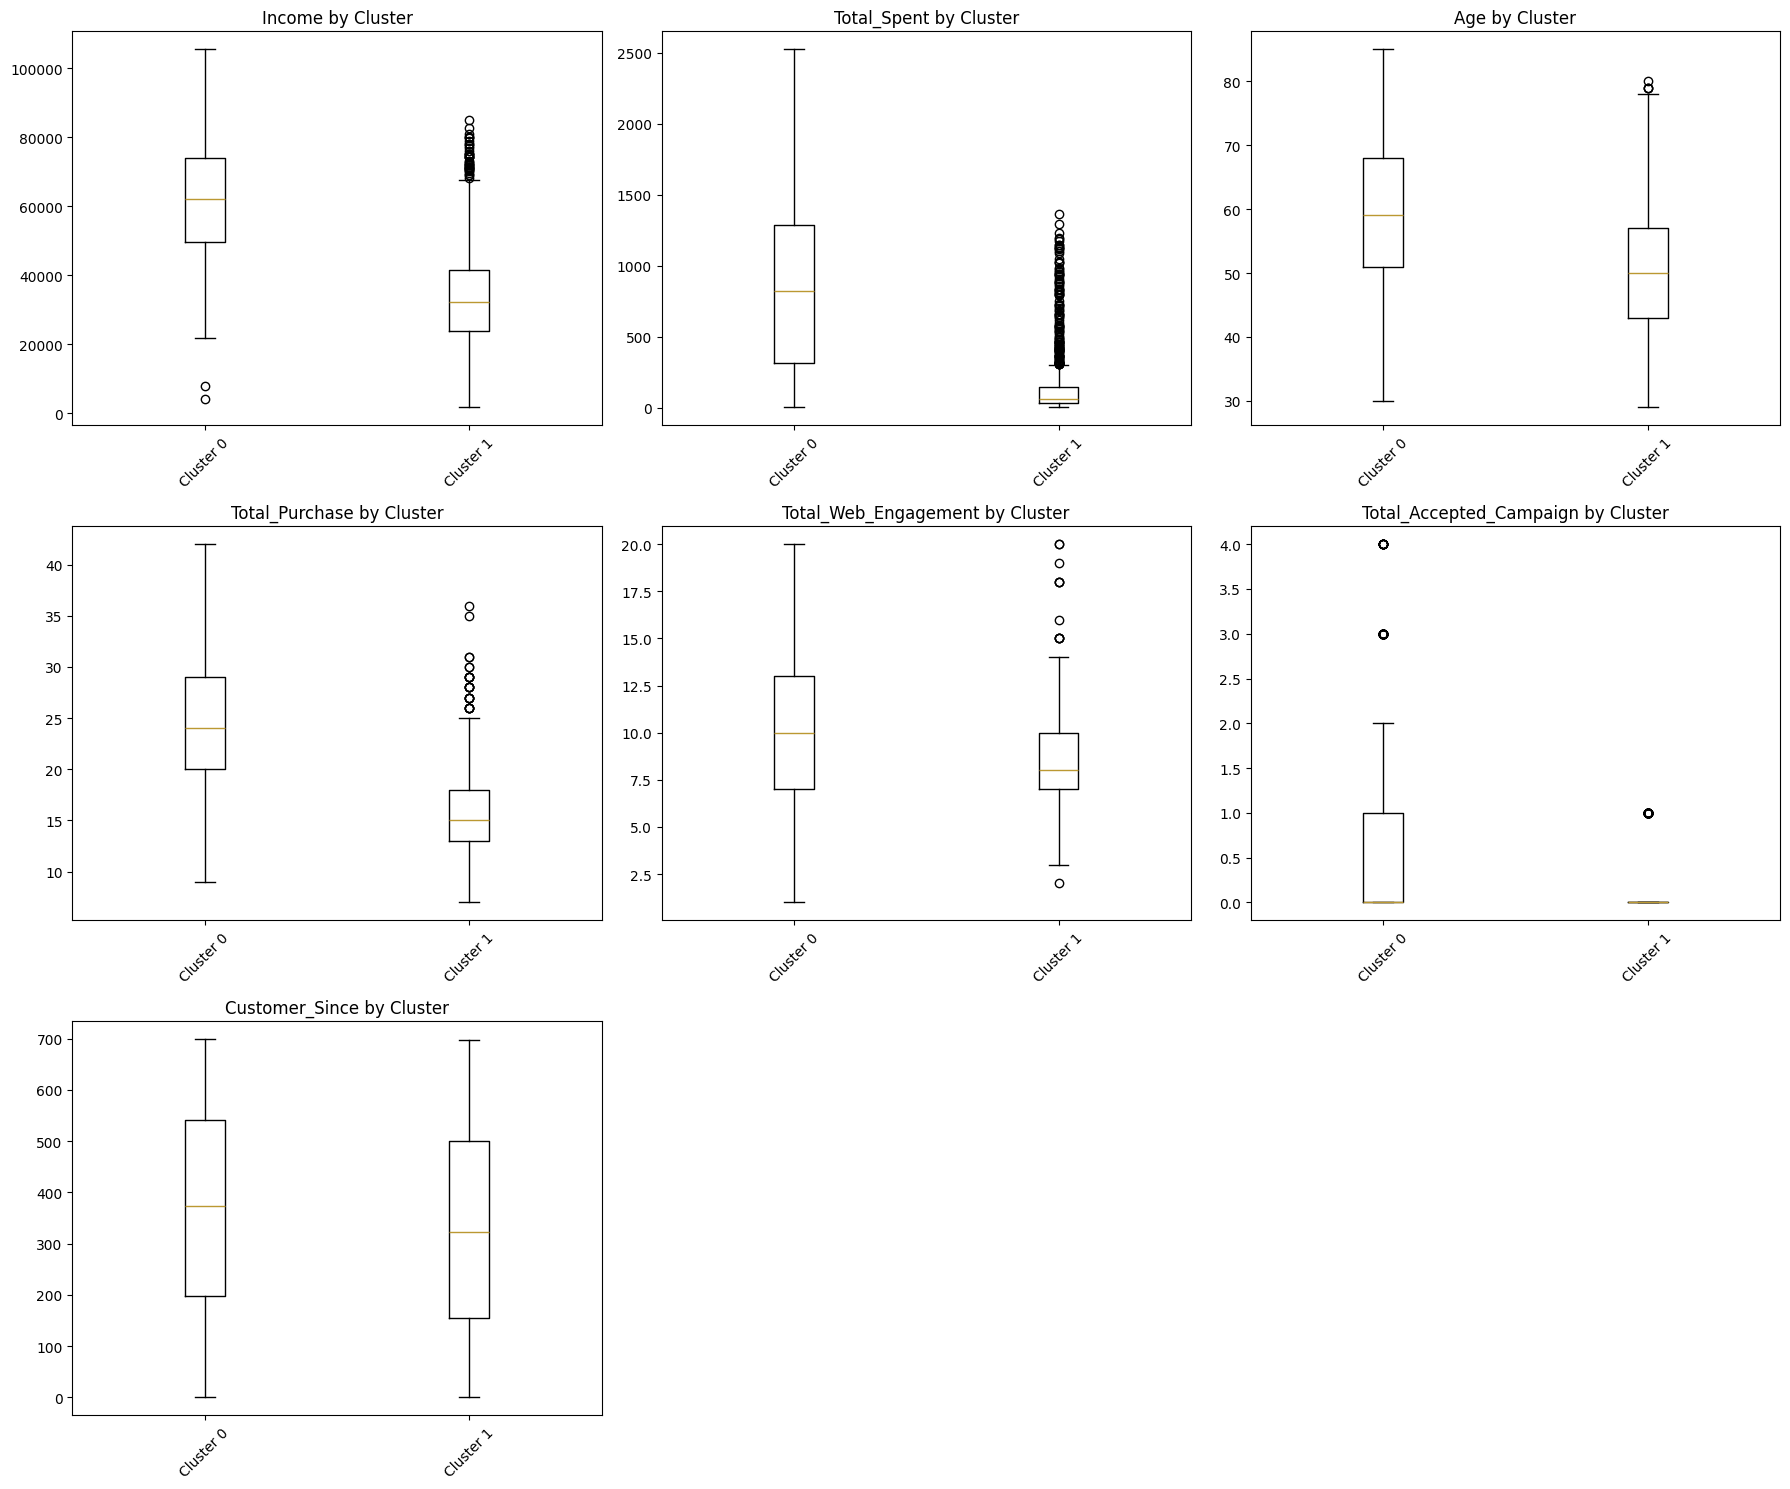

In [91]:
# Create comparison plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, metric in enumerate(key_metrics):
    if metric in cleaned_data.columns:
        cluster_data = []
        cluster_labels = []
        
        for cluster_id in sorted(clustered_data['Cluster'].unique()):
            cluster_mask = clustered_data['Cluster'] == cluster_id
            cluster_data.append(cleaned_data[cluster_mask][metric])
            cluster_labels.append(f'Cluster {cluster_id}')
        
        axes[i].boxplot(cluster_data, labels=cluster_labels)
        axes[i].set_title(f'{metric} by Cluster')
        axes[i].tick_params(axis='x', rotation=45)

# Remove empty subplots
for j in range(len(key_metrics), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('plots/cluster_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


show cleaner pattern for high and lower value customer

In [93]:
for metric in key_metrics:
    if metric in cleaned_data.columns:
        cluster_0_data = cleaned_data[clustered_data['Cluster'] == 0][metric]
        cluster_1_data = cleaned_data[clustered_data['Cluster'] == 1][metric]
        
        # T-test
        t_stat, p_value = ttest_ind(cluster_0_data, cluster_1_data)
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(cluster_0_data) - 1) * cluster_0_data.var() + 
                             (len(cluster_1_data) - 1) * cluster_1_data.var()) / 
                            (len(cluster_0_data) + len(cluster_1_data) - 2))
        cohens_d = (cluster_0_data.mean() - cluster_1_data.mean()) / pooled_std
        
        print(f"{metric}:")
        print(f"  Cluster 0 mean: {cluster_0_data.mean():.2f}")
        print(f"  Cluster 1 mean: {cluster_1_data.mean():.2f}")
        print(f"  T-statistic: {t_stat:.3f}")
        print(f"  P-value: {p_value:.6f}")
        print(f"  Cohen's d: {cohens_d:.3f}")
        print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")
        print()

Income:
  Cluster 0 mean: 61534.83
  Cluster 1 mean: 34475.75
  T-statistic: 38.651
  P-value: 0.000000
  Cohen's d: 1.713
  Significant: Yes

Total_Spent:
  Cluster 0 mean: 854.83
  Cluster 1 mean: 163.52
  T-statistic: 31.825
  P-value: 0.000000
  Cohen's d: 1.410
  Significant: Yes

Age:
  Cluster 0 mean: 59.06
  Cluster 1 mean: 51.12
  T-statistic: 16.309
  P-value: 0.000000
  Cohen's d: 0.723
  Significant: Yes

Total_Purchase:
  Cluster 0 mean: 24.27
  Cluster 1 mean: 15.77
  T-statistic: 32.896
  P-value: 0.000000
  Cohen's d: 1.458
  Significant: Yes

Total_Web_Engagement:
  Cluster 0 mean: 10.08
  Cluster 1 mean: 8.27
  T-statistic: 12.232
  P-value: 0.000000
  Cohen's d: 0.542
  Significant: Yes

Total_Accepted_Campaign:
  Cluster 0 mean: 0.43
  Cluster 1 mean: 0.07
  T-statistic: 12.628
  P-value: 0.000000
  Cohen's d: 0.560
  Significant: Yes

Customer_Since:
  Cluster 0 mean: 367.17
  Cluster 1 mean: 330.23
  T-statistic: 4.132
  P-value: 0.000037
  Cohen's d: 0.183
  Sign

In [94]:
# Analyze categorical variables
categorical_vars = ['Education', 'Marital_Status', 'Response']

for var in categorical_vars:
    if var in cleaned_data.columns:
        print(f"\n{var} distribution by cluster:")
        crosstab = pd.crosstab(clustered_data['Cluster'], cleaned_data[var], normalize='index')
        print(crosstab.round(3))


Education distribution by cluster:
Education      0      1
Cluster                
0          0.466  0.534
1          0.643  0.357

Marital_Status distribution by cluster:
Marital_Status      0      1
Cluster                     
0               0.355  0.645
1               0.352  0.648

Response distribution by cluster:
Response      0      1
Cluster               
0         0.821  0.179
1         0.902  0.098


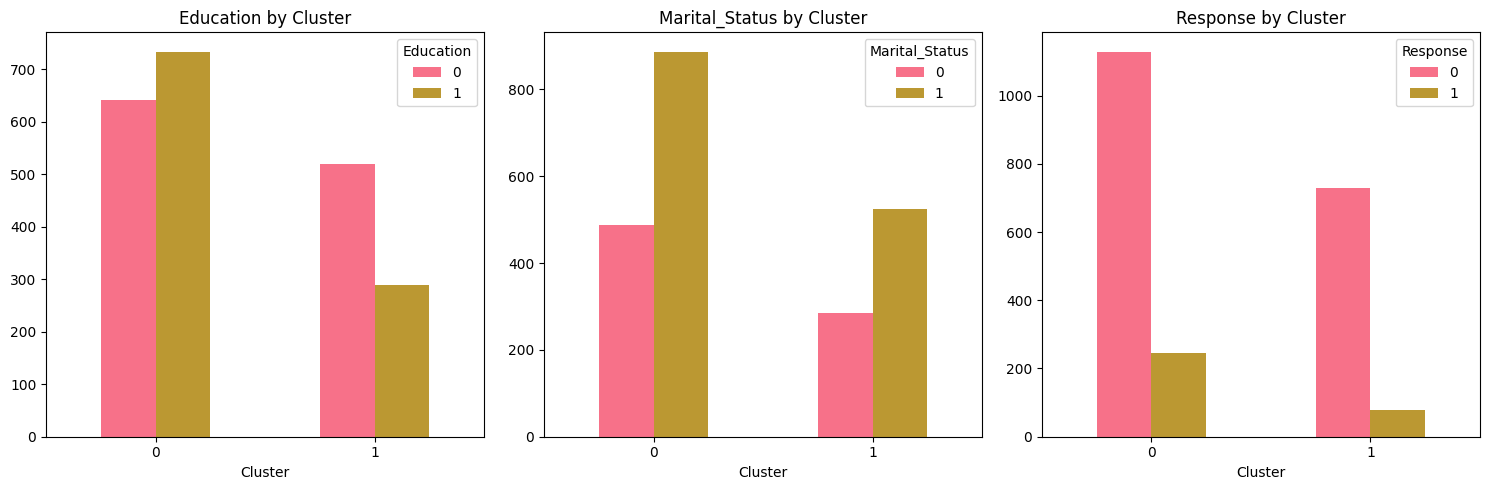

In [95]:
fig, axes = plt.subplots(1, len(categorical_vars), figsize=(15, 5))

for i, var in enumerate(categorical_vars):
    if var in cleaned_data.columns:
        crosstab = pd.crosstab(clustered_data['Cluster'], cleaned_data[var])
        crosstab.plot(kind='bar', ax=axes[i], rot=0)
        axes[i].set_title(f'{var} by Cluster')
        axes[i].set_xlabel('Cluster')
        axes[i].legend(title=var)

plt.tight_layout()
plt.savefig('plots/categorical_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

Education: Relatively balanced between clusters

Marital Status: Cluster 1 has proportionally more married customers

Response Rate: Cluster 0 has significantly higher campaign response rates

Try different numbers of clusters to see if we can find better segmentation

In [96]:
scaled_data = pd.read_csv(r"data\03_scaled_proprocessed_marketing_campaign.csv", index_col=0)
X = scaled_data.values

In [97]:
# Apply PCA
pca = PCA(n_components=13)  # Based on previous analysis
X_pca = pca.fit_transform(X)

In [98]:
# Test different cluster numbers
cluster_range = range(2, 8)
results = []

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_pca)
    
    silhouette = silhouette_score(X_pca, labels)
    inertia = kmeans.inertia_
    
    # Calculate cluster balance (how evenly distributed the clusters are)
    cluster_counts = np.bincount(labels)
    cluster_balance = np.std(cluster_counts) / np.mean(cluster_counts)
    
    results.append({
        'n_clusters': n_clusters,
        'silhouette': silhouette,
        'inertia': inertia,
        'cluster_balance': cluster_balance,
        'min_cluster_size': min(cluster_counts),
        'max_cluster_size': max(cluster_counts)
    })

results_df = pd.DataFrame(results)
print(results_df.round(3))

   n_clusters  silhouette    inertia  cluster_balance  min_cluster_size  \
0           2       0.156  29922.256            0.259               809   
1           3       0.137  26944.948            0.149               618   
2           4       0.123  24735.365            0.117               481   
3           5       0.129  23216.645            0.330               178   
4           6       0.114  22228.562            0.281               163   
5           7       0.114  21539.100            0.371               137   

   max_cluster_size  
0              1375  
1               875  
2               622  
3               617  
4               470  
5               422  


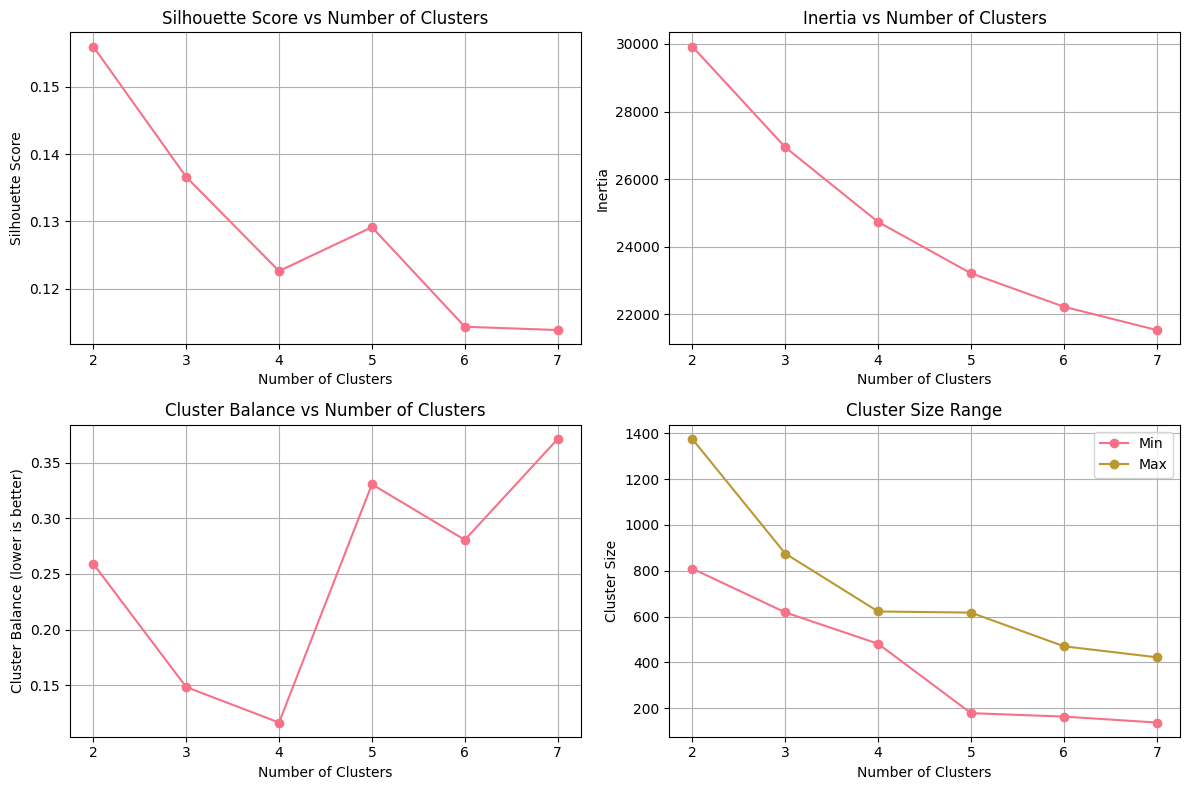

In [100]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(results_df['n_clusters'], results_df['silhouette'], 'o-')
axes[0, 0].set_title('Silhouette Score vs Number of Clusters')
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Silhouette Score')
axes[0, 0].grid(True)

axes[0, 1].plot(results_df['n_clusters'], results_df['inertia'], 'o-')
axes[0, 1].set_title('Inertia vs Number of Clusters')
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].set_ylabel('Inertia')
axes[0, 1].grid(True)

axes[1, 0].plot(results_df['n_clusters'], results_df['cluster_balance'], 'o-')
axes[1, 0].set_title('Cluster Balance vs Number of Clusters')
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].set_ylabel('Cluster Balance (lower is better)')
axes[1, 0].grid(True)

axes[1, 1].plot(results_df['n_clusters'], results_df['min_cluster_size'], 'o-', label='Min')
axes[1, 1].plot(results_df['n_clusters'], results_df['max_cluster_size'], 'o-', label='Max')
axes[1, 1].set_title('Cluster Size Range')
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].set_ylabel('Cluster Size')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('plots/cluster_optimization.png', dpi=300, bbox_inches='tight')
plt.show()

For 2 clusters:

Silhouette Score: 0.156 (moderate separation)

Inertia: Shows elbow at k=3-4

Balance: Good at k=2 (0.26)

The optimal number of clusters appears to be 2 based on silhouette score. However, this creates very unbalanced clusters (1375 vs 809 customers). The silhouette score of 0.156 suggests weak cluster separation. It confirms that there is no clear segmentation. Characteristics reveal that Cluster 0 has higher income, spending, and engagement than Cluster 1, which indicates that customers in this dataset may not have very distinct segments.

The most clustering algorithms favor two clusters with weak separation (silhouette 0.156) The two groups differ significantly in income, spending, age, and purchase behavior, indicating meaningful, though weak, segmentation. This suggests customers are quite homogeneous, so for better interpretability, I will proceed to build supervised models using these clusters as labels to derive better insights.